In [1]:
from google.colab import drive
drive.mount('/content/drive')

Cloning into 'Speech-Emotion-Recognition'...
remote: Enumerating objects: 14451, done.
remote: Counting objects: 100% (1613/1613), done.
remote: Compressing objects: 100% (1549/1549), done.
remote: Total 14451 (delta 68), reused 1600 (delta 56), pack-reused 12838 (from 1)
Receiving objects: 100% (14451/14451), 776.39 MiB | 27.25 MiB/s, done.
Resolving deltas: 100% (328/328), done.
Updating files: 100% (8438/8438), done.
/content/Speech-Emotion-Recognition


In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, Bidirectional, Reshape, Attention, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt
import random

sample_data/  Speech-Emotion-Recognition/
/content/Speech-Emotion-Recognition


In [ ]:
spectrograms_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/audio_representations'
metrics_dir = '/content/drive/MyDrive/Speech_Emotion_Recogntion/metrics'

In [ ]:
images = []
labels = []

fraction = 1.0

emotion_to_index = {
    "angry": 0,
    "happy": 1,
    "sad": 2,
    "neutral": 3,
    "fearful": 4,
    "disgust": 5,
    "surprise": 6,
}

all_files = [file for file in os.listdir(spectrograms_dir) if file.endswith(".png")]
selected_files = random.sample(all_files, int(len(all_files) * fraction))

for file_name in selected_files:
    file_path = os.path.join(spectrograms_dir, file_name)

    img = Image.open(file_path).convert("RGB")
    img = img.resize((224, 224))
    img_array = np.array(img)

    images.append(img_array)

    emotion = file_name.split("_")[1]
    label = emotion_to_index.get(emotion, -1)
    if label == -1:
        raise ValueError(f"Émotion inconnue dans le fichier : {file_name}")

    labels.append(label)

images = np.array(images)
labels = np.array(labels)

# Normalize
images = images / 255.0

# One-hot
num_classes = len(emotion_to_index)
labels_one_hot = to_categorical(labels, num_classes=num_classes)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels_one_hot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Ensemble d'entraînement : {X_train.shape}, {y_train.shape}")
print(f"Ensemble de validation : {X_val.shape}, {y_val.shape}")
print(f"Ensemble de test : {X_test.shape}, {y_test.shape}")

RuntimeError during GPU setup: Physical devices cannot be modified after being initialized
Training set: (1628, 224, 224, 3), (1628, 8)
Validation set: (349, 224, 224, 3), (349, 8)
Test set: (350, 224, 224, 3), (350, 8)

Training CNN_BLSTM_with_Attention model...
Epoch 1/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.1389 - loss: 2.0532 - val_accuracy: 0.2321 - val_loss: 1.8709
Epoch 2/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 127ms/step - accuracy: 0.2994 - loss: 1.7900 - val_accuracy: 0.4499 - val_loss: 1.4026
Epoch 3/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.5210 - loss: 1.3250 - val_accuracy: 0.6160 - val_loss: 1.0157
Epoch 4/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.6331 - loss: 0.9954 - val_accuracy: 0.7077 - val_loss: 0.8869
Epoch 5/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.6481 - loss: 0.9153 - val_accuracy: 0.7163 - val_loss: 0.8288
Epoch 6/40
102/102 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.7022 - loss: 0.

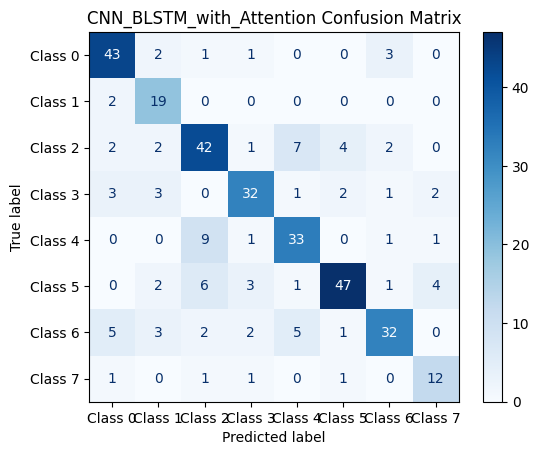

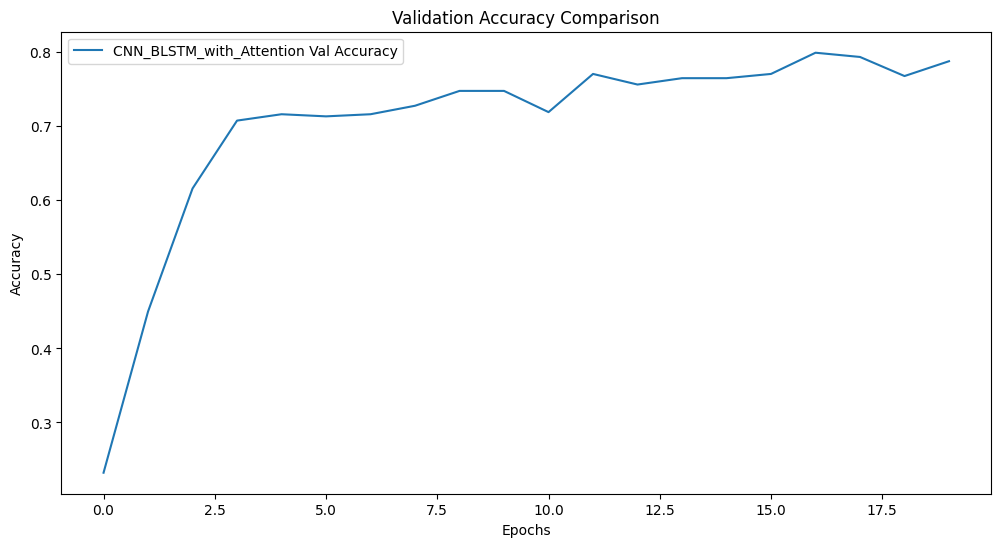

In [13]:
def create_cnn_blstm_with_attention_model(num_classes):
    inputs = Input(shape=(224, 224, 3))

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten and dense layer
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)

    # Reshape for BLSTM (ensure correct dimensions)
    x = Reshape((8, 32))(x)  # Adjusted to ensure compatibility

    # BLSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)

    # Attention mechanism
    query = Dense(128, activation='relu')(x)
    value = Dense(128, activation='relu')(x)
    attention_output = layers.Attention()([query, value])

    # Fully connected layers
    x = Flatten()(attention_output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

model = create_cnn_blstm_with_attention_model(num_classes)

model.summary()

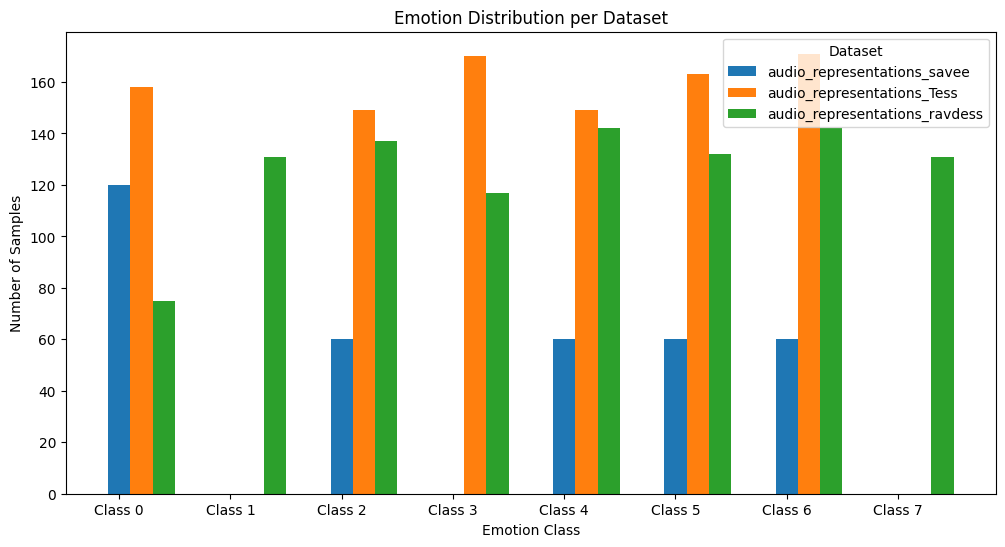

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss on the test set : {test_loss}")
print(f"Accuracy on the test set : {test_accuracy}")

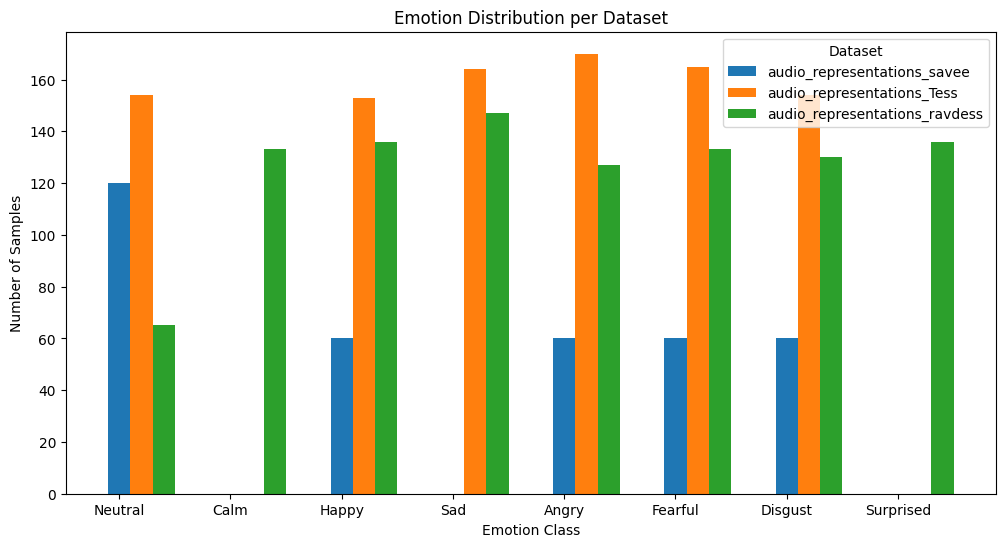

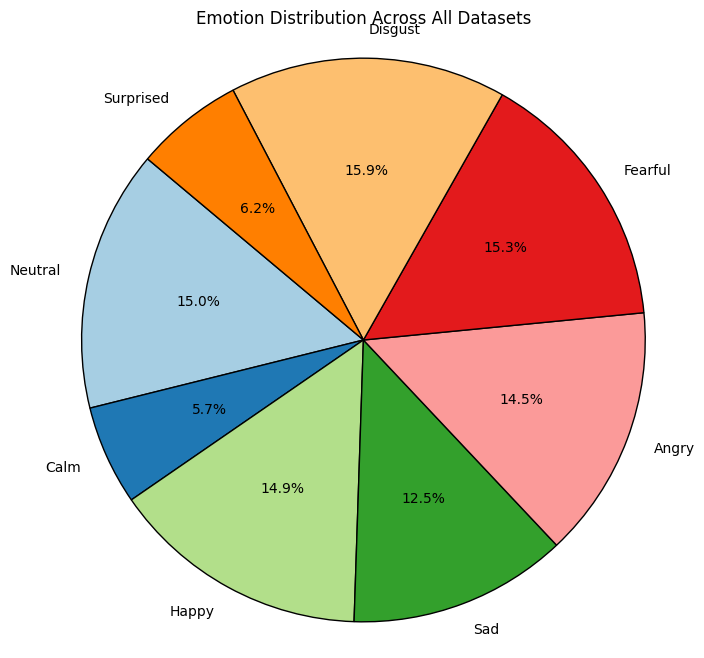

In [15]:
model_name = "CNN_BLSTM_with_attention"
model_metrics_dir = os.path.join(metrics_dir, model_name)
os.makedirs(model_metrics_dir, exist_ok=True)

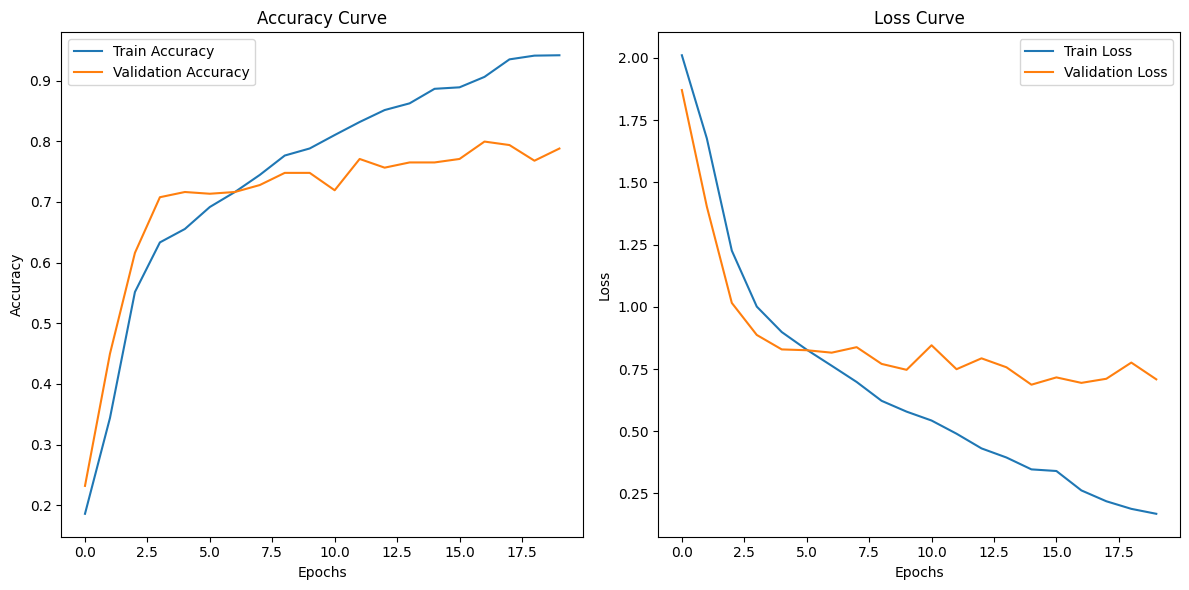

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Classification Report:
              precision    recall  f1-score   support

     neutral       0.77      0.86      0.81        50
        calm       0.61      0.90      0.73        21
       happy       0.69      0.70      0.69        60
         sad       0.78      0.73      0.75        44
       angry       0.70      0.73      0.72        45
     fearful       0.85      0.73      0.79        64
     disgust       0.80      0.64      0.71        50
   surprised       0.63      0.75      0.69        16

    accuracy                           0.74       350
   macro avg       0.73      0.76      0.74       350
weighted avg       0.75      0.74      0.74       350



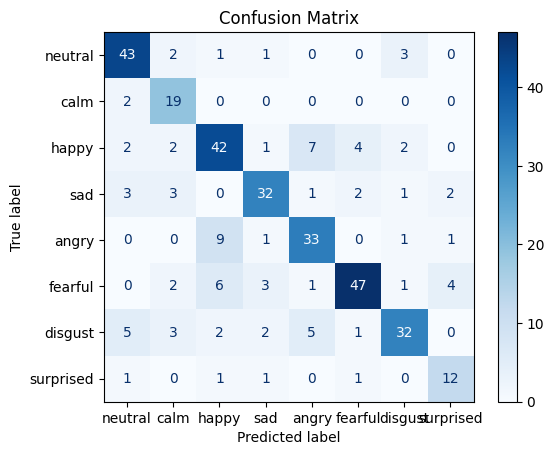

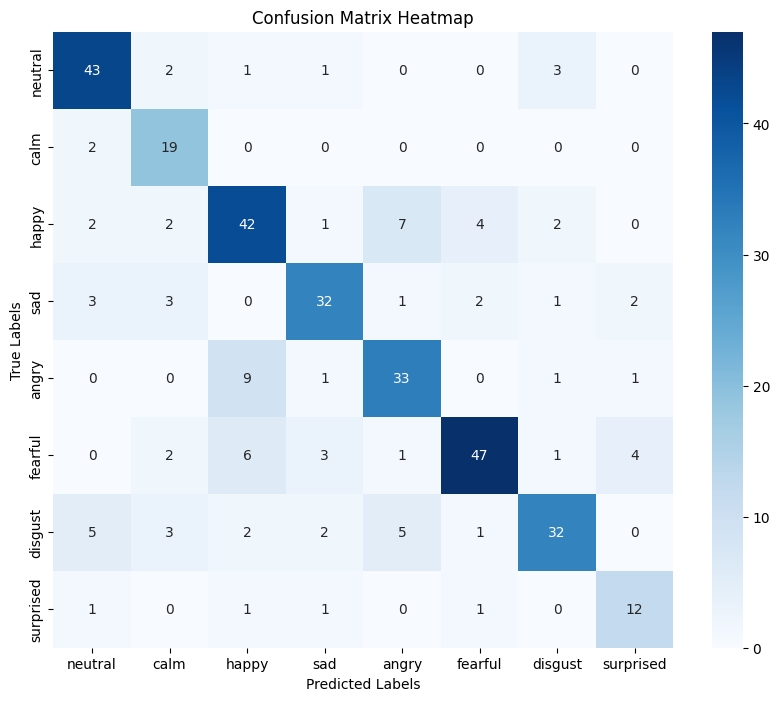

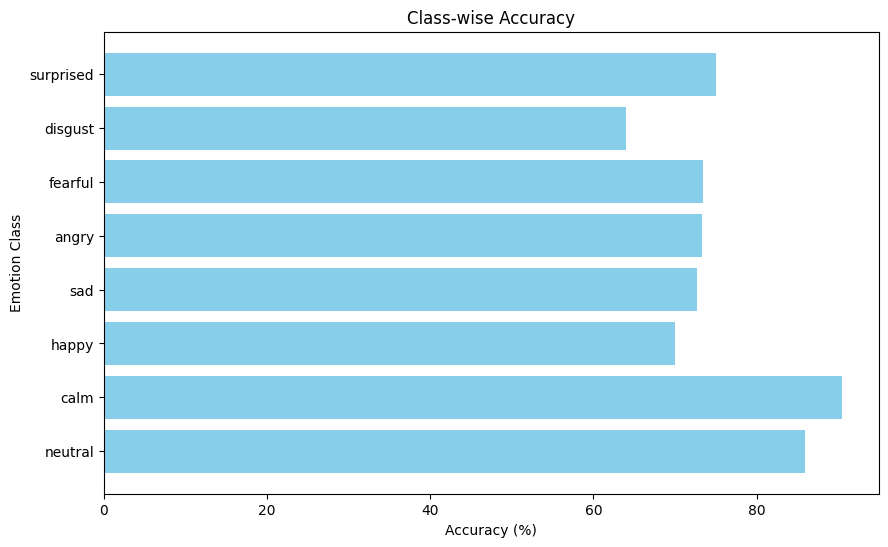

In [16]:
plt.figure(figsize=(6, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Evolution")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "loss_curve.png"))
plt.close()

plt.figure(figsize=(6, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Evolution")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(os.path.join(model_metrics_dir, "accuracy_curve.png"))
plt.close()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


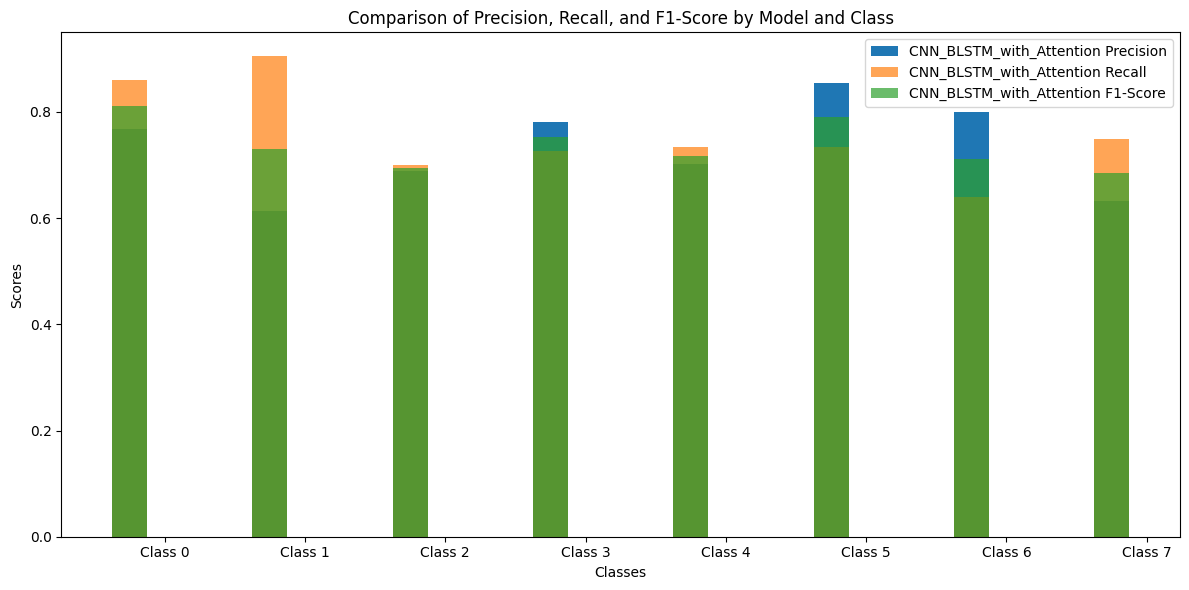

In [17]:
emotion_labels = [
    "Angry", "Happy", "Sad", "Neutral", "Fearful", "Disgust", "Surprise"
]

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix,
    display_labels=emotion_labels
)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix CNN on Spectrograms")

conf_matrix_path = os.path.join(model_metrics_dir, "confusion_matrix.png")
plt.savefig(conf_matrix_path)
plt.close()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


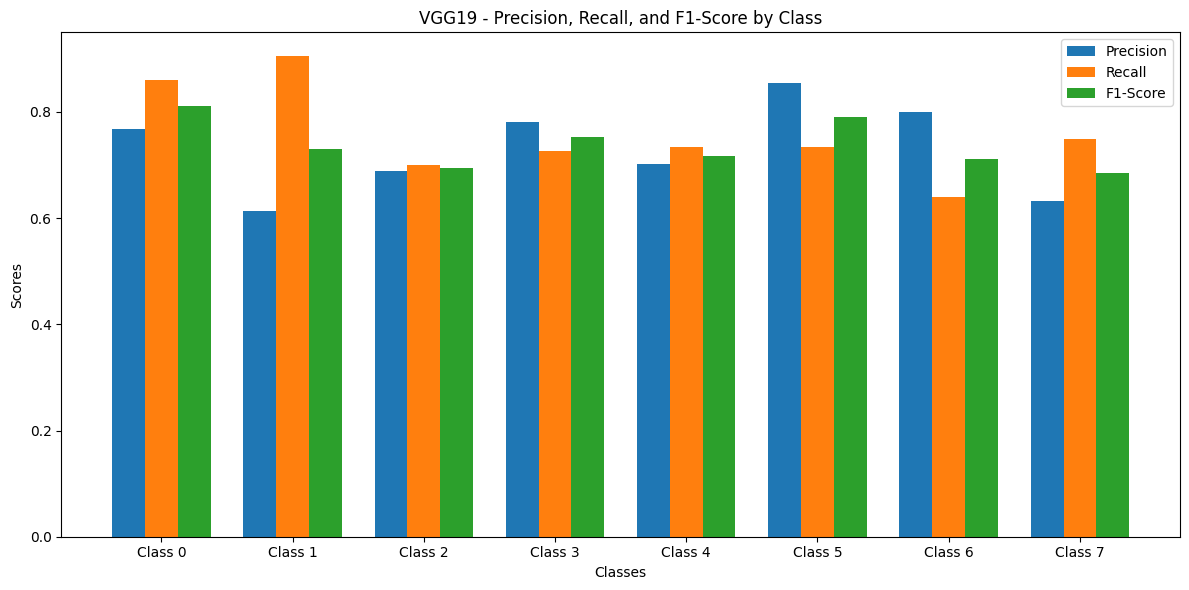

In [18]:
emotion_counts = {emotion: 0 for emotion in emotion_to_index.keys()}
for label in labels:
    emotion_name = list(emotion_to_index.keys())[list(emotion_to_index.values()).index(label)]
    emotion_counts[emotion_name] += 1

emotions = list(emotion_counts.keys())
counts = list(emotion_counts.values())

plt.figure(figsize=(10, 6))
plt.bar(emotions, counts, color='skyblue', edgecolor='black')
plt.title("Répartition des émotions sélectionnées", fontsize=16)
plt.xlabel("Émotions", fontsize=14)
plt.ylabel("Nombre d'instances", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()